In [37]:
import urllib.request as r
from bs4 import BeautifulSoup as BS
import pandas as pd
import re

In [78]:
import seaborn as sns

In [113]:
%matplotlib notebook

In [62]:
def replace_except_end(not_end_string, end_string):
    #assuming that the only matching group you have is looking for the end-of-string character
    def do_replace(matchobj):
        if matchobj.group(1) == "":
            return end_string
        return not_end_string
    return do_replace

In [119]:
# get list of stations by market
soup = BS(r.urlopen("https://en.wikipedia.org/wiki/List_of_United_States_television_markets"), "html5lib")
table = soup.find("table")
header_row = table.find_all("tr")[0]
headers = [" ".join([s.strip() for s in h.strings]) for h in header_row.find_all("th")]
df = pd.DataFrame(columns=headers)
print(headers)
data_rows = table.find_all("tr")[1:]
for row in data_rows:
    cells = row.find_all(["td", "th"])
    if len(cells) < 10:
        new_cells = []
        for i, cell in enumerate(cells):
            for j in range(int(cell.get('colspan',1))):
                new_cells.append(cell)
        print(len(new_cells))
        cells = new_cells
    df = df.append(pd.DataFrame([[" ".join([s.strip() for s in d.strings]) for d in cells]], columns=headers))
df = df.reset_index(drop=True)
df["other stations"] = None
for row in df.itertuples():
    s = row._10.replace(",","")
    df["other stations"].iloc[row.Index] = re.sub("\s*\(.+?\)\s*($)?",replace_except_end(", ", ""), s)

['Rank', 'Market', 'State', 'Counties (or county-equivalents) covered', 'TV households (2017–18)', 'Local ABC affiliate', 'Local CBS affiliate', 'Local Fox affiliate', 'Local NBC affiliate', 'Other significant stations']
10
10
10
10


In [111]:
df

,Rank,Market,State,Counties (or county-equivalents) covered,TV households (2017–18),Local ABC affiliate,Local CBS affiliate,Local Fox affiliate,Local NBC affiliate,Other significant stations,other stations,rank,num_stations
0,1,New York,New York,"New York : Bronx , Dutchess , Kings , Nassa...","7,074,750 (6.309%)",WABC-TV,WCBS-TV,WNYW,WNBC,WFTY-DT ( Justice Network ) WFUT-DT ( UniMás ...,"WFTY-DT, WFUT-DT, WLNY-TV, WPXN-TV, WTBY-TV, W...",1.0,13
1,2,Los Angeles,California,"Inyo , Kern (Sierra Nevada), Los Angeles , Ora...","5,318,630 (4.743%)",KABC-TV,KCBS-TV,KTTV,KNBC,KCAL-TV ( Independent ) KCOP-TV ( MyNetworkTV...,"KCAL-TV, KCOP-TV, KFTR-DT, KMEX, KTLA, KVEA, K...",2.0,12
2,3,Chicago,Illinois,"Illinois : Cook , DeKalb , DuPage , Grundy ...","3,299,720 (2.942%)",WLS-TV,WBBM-TV,WFLD,WMAQ-TV,WGBO-DT ( Univision ) WGN-TV ( Independent ) ...,"WGBO-DT, WGN-TV, WWTO-TV, WCPX-TV, WPWR-TV, [1...",3.0,11
3,4,Philadelphia,Pennsylvania,"Pennsylvania : Berks , Bucks , Chester , De...","2,869,580 (2.559%)",WPVI-TV,KYW-TV,WTXF-TV,WCAU,WFPA-CD ( UniMás ) WPHL ( MyNetworkTV ) WPSG...,"WFPA-CD, WPHL, WPSG, WUVP-DT, WWSI, WGTW-TV, W...",4.0,11
4,5,Dallas - Fort Worth,Texas,"Anderson , Bosque , Collin , Comanche , Cooke ...","2,648,490 (2.362%)",WFAA,KTVT,KDFW,KXAS-TV,KDAF ( CW ) KDFI ( MyNetworkTV ) KSTR-DT ( U...,"KDAF, KDFI, KSTR-DT, KTXA, KUVN-DT, KXTX-TV, K...",5.0,12
5,6,Washington ( Hagerstown ),District of Columbia,District of Columbia : Washington Virginia...,"2,492,170 (2.222%)",WJLA-TV,WUSA,WTTG,WRC-TV,WDCA ( MyNetworkTV ) WDCW ( CW ) WDVM-TV ( I...,"WDCA, WDCW, WDVM-TV, WFDC-DT, WJAL, WMDO-CD, W...",6.0,12
6,7,Houston,Texas,"Austin , Brazoria , Calhoun , Chambers , Color...","2,467,140 (2.200%)",KTRK-TV,KHOU,KRIV,KPRC-TV,KFTH-DT ( UniMás ) KIAH ( CW ) KXLN-DT ( Uni...,"KFTH-DT, KIAH, KXLN-DT, KTXH, KTMD, KPXB-TV, K...",7.0,11
7,8,San Francisco - Oakland - San Jose,California,"Alameda , Contra Costa , Lake , Marin , Mendoc...","2,451,640 (2.186%)",KGO-TV,KPIX-TV,KTVU,KNTV,KBCW ( CW ) KDTV ( Univision ) KFSF-DT ( Uni...,"KBCW, KDTV, KFSF-DT, KICU-TV, KRON-TV, KSTS, K...",8.0,11
8,9,Atlanta,Georgia,"Georgia : Banks , Barrow , Bartow , Butts ,...","2,449,460 (2.184%)",WSB-TV,WGCL-TV,WAGA-TV,WXIA-TV,WATL ( MyNetworkTV ) WPCH-TV ( Independent ) ...,"WATL, WPCH-TV, WUPA, WUVG-DT, WPXA-TV, WHSG-TV...",9.0,11
9,10,Boston ( Manchester ),Massachusetts,"Massachusetts : Barnstable , Dukes , Essex ...","2,425,440 (2.163%)",WCVB-TV WMUR-TV,WBZ-TV,WFXT,WBTS-LD / WYCN-CD / WNEU-DT2 /WMFP-DT5,WHDH ( Independent ) WLVI ( CW ) WNEU ( Tele...,"WHDH, WLVI, WNEU, WSBK-TV, WUNI, WUTF-DT, WBPX-TV",10.0,11


In [120]:
df["num_stations"] = 0
for row in df.itertuples():
    num = 0
    if row._6 != "-":
        num += 1
    if row._7 != "-":
        num += 1
    if row._8 != "-":
        num += 1
    if row._9 != "-":
        num += 1
    if row._10 != "-":
        num += len(row._11.split(","))
    df["num_stations"].iloc[row.Index] = num

c:\python36\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [121]:
df["rank"] = df["Rank"].replace(["N/A"], [None])
df["rank"] = pd.to_numeric(df["rank"], downcast="integer", errors="coerce")

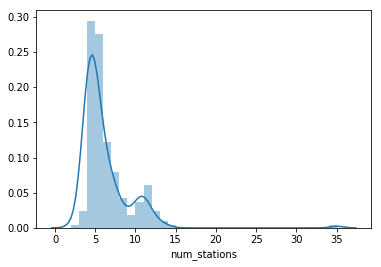

In [103]:
sns.distplot(df["num_stations"])

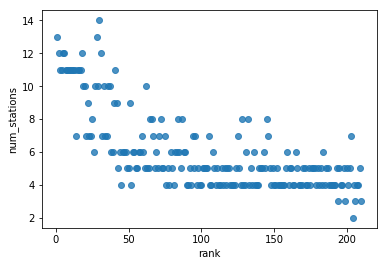

In [110]:
sns.regplot(y="num_stations", x="rank", data=df, dropna=True, fit_reg=False)

<IPython.core.display.Javascript object>


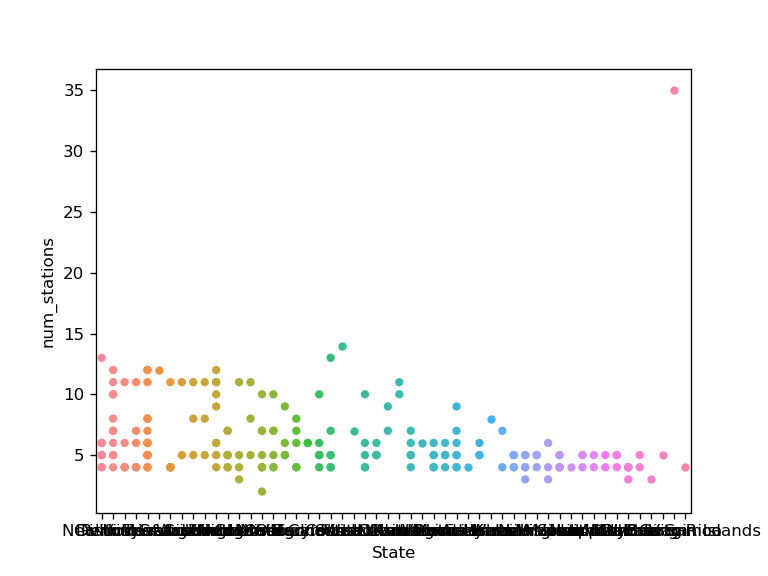

In [115]:
sns.stripplot(x="State", y="num_stations", data=df)

In [164]:
# get sinclair owned stations
soup = BS(r.urlopen("https://en.wikipedia.org/wiki/List_of_stations_owned_or_operated_by_Sinclair_Broadcast_Group"), "html5lib")
table = soup.find_all("table")[1]
header_row = table.find_all("tr")[0]
headers = [" ".join([s.strip() for s in h.strings]) for h in header_row.find_all("th")]
sinclair_df = pd.DataFrame(columns=headers)
print(headers)
data_rows = table.find_all("tr")[1:]
propogate_forward = [None for i in range(len(headers))]
for row in data_rows:
    cells = row.find_all(["td", "th"])
    for i, p in enumerate(propogate_forward):
        if p:
            if p[1] > 0:
                cells.insert(i, p[0])
                p[1] -= 1
            if p[1] == 0:
                p = None
    for i, cell in enumerate(cells):
        if cell.get('rowspan', None) != None:
            propogate_forward[i] = [cell, int(cell.get('rowspan'))-1]
            del cell['rowspan']
    #print(len(cells))
    
    if len(cells) == 8:
        sinclair_df = sinclair_df.append(pd.DataFrame([[" ".join([s.strip() for s in d.strings]) for d in cells]], columns=headers))
    else:
        print("skipped")
        print([" ".join([s.strip() for s in d.strings]) for d in cells])
sinclair_df = sinclair_df.reset_index(drop=True)

['City of license / Market', 'Station', 'Channel  TV ( RF )', 'Year acquired', 'DT1 affiliation', 'DT2 affiliation', 'DT3 affiliation', 'DT4 affiliation']


In [150]:
sinclair_df

,City of license / Market,Station,Channel TV ( RF ),Year acquired,DT1 affiliation,DT2 affiliation,DT3 affiliation,DT4 affiliation
0,"Birmingham - Tuscaloosa - Anniston, AL",WTTO,21 (28),1995,The CW,Antenna TV,Comet,TBD
1,"Birmingham - Tuscaloosa - Anniston, AL",WABM,68 (36),2001,MyNetworkTV,ABC ( WBMA-LD simulcast),weather,
2,"Birmingham - Tuscaloosa - Anniston, AL",WDBB 1 (satellite of WTTO),17 (18),1995,The CW,ABC ( WBMA-LD simulcast),,
3,"Birmingham - Tuscaloosa - Anniston, AL",WBMA-LD α,58 (40),2014,ABC,weather,Stadium,Charge!
4,"Mobile, AL & Pensacola, FL",WEAR-TV,3 (17),1997,ABC,TBD,Charge!,
5,"Mobile, AL & Pensacola, FL",WPMI-TV ∞ 2,15 (15),2012,NBC,WeatherNation TV,Stadium,
6,"Mobile, AL & Pensacola, FL",WFGX,35 (50),2001,MyNetworkTV & This TV,GetTV,Comet,
7,"Mobile, AL & Pensacola, FL",WJTC ∞ 2,44 (45),2012,Independent,Grit,,
8,"Little Rock, AR",KATV α,7 (22),2014,ABC,Comet,Charge!,TBD
9,"Bakersfield, CA",KBAK-TV §§,29 (33),2013,CBS,Charge!,Fox ( KBFX-CD simulcast),


In [170]:
def process_sinclair(sdf):
    sdf["year"] = 0
    sdf["call_sign"] = ""
    for row in sdf.itertuples():
        #print(row._4)
        y = int(row._4.split(" ")[0])
        sdf["year"].iloc[row.Index] = y
        cs = row.Station.split(" ")[0]
        sdf["call_sign"].iloc[row.Index] = cs

In [171]:
process_sinclair(sinclair_df)

c:\python36\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [172]:
sinclair_df[["year", "call_sign"]]

,year,call_sign
0,1995,WTTO
1,2001,WABM
2,1995,WDBB
3,2014,WBMA-LD
4,1997,WEAR-TV
5,2012,WPMI-TV
6,2001,WFGX
7,2012,WJTC
8,2014,KATV
9,2013,KBAK-TV


In [176]:
df["abc"] = df["Local ABC affiliate"].map(lambda x: re.sub("\s+"," ",re.sub("\(.+?\)","",x.strip())))
df["cbs"] = df["Local CBS affiliate"].map(lambda x: re.sub("\s+"," ",re.sub("\(.+?\)","",x.strip())))
df["fox"] = df["Local Fox affiliate"].map(lambda x: re.sub("\s+"," ",re.sub("\(.+?\)","",x.strip())))
df["nbc"] = df["Local NBC affiliate"].map(lambda x: re.sub("\s+"," ",re.sub("\(.+?\)","",x.strip())))

In [177]:
df

,Rank,Market,State,Counties (or county-equivalents) covered,TV households (2017–18),Local ABC affiliate,Local CBS affiliate,Local Fox affiliate,Local NBC affiliate,Other significant stations,other stations,num_stations,rank,abc,cbs,fox,nbc
0,1,New York,New York,"New York : Bronx , Dutchess , Kings , Nassa...","7,074,750 (6.309%)",WABC-TV,WCBS-TV,WNYW,WNBC,WFTY-DT ( Justice Network ) WFUT-DT ( UniMás ...,"WFTY-DT, WFUT-DT, WLNY-TV, WPXN-TV, WTBY-TV, W...",13,1.0,WABC-TV,WCBS-TV,WNYW,WNBC
1,2,Los Angeles,California,"Inyo , Kern (Sierra Nevada), Los Angeles , Ora...","5,318,630 (4.743%)",KABC-TV,KCBS-TV,KTTV,KNBC,KCAL-TV ( Independent ) KCOP-TV ( MyNetworkTV...,"KCAL-TV, KCOP-TV, KFTR-DT, KMEX, KTLA, KVEA, K...",12,2.0,KABC-TV,KCBS-TV,KTTV,KNBC
2,3,Chicago,Illinois,"Illinois : Cook , DeKalb , DuPage , Grundy ...","3,299,720 (2.942%)",WLS-TV,WBBM-TV,WFLD,WMAQ-TV,WGBO-DT ( Univision ) WGN-TV ( Independent ) ...,"WGBO-DT, WGN-TV, WWTO-TV, WCPX-TV, WPWR-TV, [1...",11,3.0,WLS-TV,WBBM-TV,WFLD,WMAQ-TV
3,4,Philadelphia,Pennsylvania,"Pennsylvania : Berks , Bucks , Chester , De...","2,869,580 (2.559%)",WPVI-TV,KYW-TV,WTXF-TV,WCAU,WFPA-CD ( UniMás ) WPHL ( MyNetworkTV ) WPSG...,"WFPA-CD, WPHL, WPSG, WUVP-DT, WWSI, WGTW-TV, W...",11,4.0,WPVI-TV,KYW-TV,WTXF-TV,WCAU
4,5,Dallas - Fort Worth,Texas,"Anderson , Bosque , Collin , Comanche , Cooke ...","2,648,490 (2.362%)",WFAA,KTVT,KDFW,KXAS-TV,KDAF ( CW ) KDFI ( MyNetworkTV ) KSTR-DT ( U...,"KDAF, KDFI, KSTR-DT, KTXA, KUVN-DT, KXTX-TV, K...",12,5.0,WFAA,KTVT,KDFW,KXAS-TV
5,6,Washington ( Hagerstown ),District of Columbia,District of Columbia : Washington Virginia...,"2,492,170 (2.222%)",WJLA-TV,WUSA,WTTG,WRC-TV,WDCA ( MyNetworkTV ) WDCW ( CW ) WDVM-TV ( I...,"WDCA, WDCW, WDVM-TV, WFDC-DT, WJAL, WMDO-CD, W...",12,6.0,WJLA-TV,WUSA,WTTG,WRC-TV
6,7,Houston,Texas,"Austin , Brazoria , Calhoun , Chambers , Color...","2,467,140 (2.200%)",KTRK-TV,KHOU,KRIV,KPRC-TV,KFTH-DT ( UniMás ) KIAH ( CW ) KXLN-DT ( Uni...,"KFTH-DT, KIAH, KXLN-DT, KTXH, KTMD, KPXB-TV, K...",11,7.0,KTRK-TV,KHOU,KRIV,KPRC-TV
7,8,San Francisco - Oakland - San Jose,California,"Alameda , Contra Costa , Lake , Marin , Mendoc...","2,451,640 (2.186%)",KGO-TV,KPIX-TV,KTVU,KNTV,KBCW ( CW ) KDTV ( Univision ) KFSF-DT ( Uni...,"KBCW, KDTV, KFSF-DT, KICU-TV, KRON-TV, KSTS, K...",11,8.0,KGO-TV,KPIX-TV,KTVU,KNTV
8,9,Atlanta,Georgia,"Georgia : Banks , Barrow , Bartow , Butts ,...","2,449,460 (2.184%)",WSB-TV,WGCL-TV,WAGA-TV,WXIA-TV,WATL ( MyNetworkTV ) WPCH-TV ( Independent ) ...,"WATL, WPCH-TV, WUPA, WUVG-DT, WPXA-TV, WHSG-TV...",11,9.0,WSB-TV,WGCL-TV,WAGA-TV,WXIA-TV
9,10,Boston ( Manchester ),Massachusetts,"Massachusetts : Barnstable , Dukes , Essex ...","2,425,440 (2.163%)",WCVB-TV WMUR-TV,WBZ-TV,WFXT,WBTS-LD / WYCN-CD / WNEU-DT2 /WMFP-DT5,WHDH ( Independent ) WLVI ( CW ) WNEU ( Tele...,"WHDH, WLVI, WNEU, WSBK-TV, WUNI, WUTF-DT, WBPX-TV",11,10.0,WCVB-TV WMUR-TV,WBZ-TV,WFXT,WBTS-LD / WYCN-CD / WNEU-DT2 /WMFP-DT5


In [178]:
dma_codes = pd.read_json("tv.json", orient="index")

In [179]:
dma_codes

,% of US,DMA Code,Designated Market Area (DMA),Rank,TV Homes
500,0.341,500,Portland-Auburn,80,389530
501,6.468,501,New York,1,7384340
502,0.117,502,Binghamton,157,133420
503,0.211,503,Macon,120,241170
504,2.583,504,Philadelphia,4,2949310
505,1.617,505,Detroit,11,1845920
506,2.073,506,Boston (Manchester),7,2366690
507,0.293,507,Savannah,92,334750
508,1.021,508,Pittsburgh,23,1165740
509,0.232,509,Ft. Wayne,109,265390


In [227]:
from fuzzywuzzy import process, fuzz

In [187]:
df.Market.map(lambda name: process.extractOne(name, list(dma_codes["Designated Market Area (DMA)"].values))[0])

0                        New York
1                     Los Angeles
2                         Chicago
3                    Philadelphia
4                Dallas-Ft. Worth
5       Washington, DC (Hagrstwn)
6                         Houston
7      San Francisco-Oak-San Jose
8                         Atlanta
9             Boston (Manchester)
10             Phoenix (Prescott)
11                 Seattle-Tacoma
12            Richmond-Petersburg
13                        Detroit
14           Minneapolis-St. Paul
15           Miami-Ft. Lauderdale
16                         Denver
17                         Dayton
18       Cleveland-Akron (Canton)
19       Sacramnto-Stkton-Modesto
20                      St. Louis
21                   Portland, OR
22                      Charlotte
23                     Pittsburgh
24     Raleigh-Durham (Fayetvlle)
25                      Baltimore
26                      Nashville
27                   Indianapolis
28                      San Diego
29            

In [254]:
stations_long_form = pd.DataFrame(columns = ["market_name", "station_name", "dma_code", "sinclair_owned", "dma_market"])
usual_columns = ["abc", "nbc", "fox", "cbs"]
for row in df.itertuples():
    if row.Market == "N/A":
        continue
    # using token sort ratio seems to work pretty well (something to do with abbreviated names)
    # except for columbus GA matching to columbus OH
    m = None
    if row.Market == "Columbus, GA":
        print("here")
        m = "Columbus, GA (Opelika, AL)"
    else:
        m = row.Market
    dma_match = process.extract(m, list(dma_codes["Designated Market Area (DMA)"].values), scorer=fuzz.token_sort_ratio)
    print(row.Market, dma_match[0])
    dma_name = dma_match[0][0]
    dma_code = dma_codes[dma_codes["Designated Market Area (DMA)"] == dma_name].iloc[0]["DMA Code"]
    for col in usual_columns:
        if getattr(row, col).strip() == "-":
            pass
        else:
            for stat in getattr(row, col).split("/"):
                stations_long_form = stations_long_form.append({"market_name" : row.Market,
                                           "station_name": stat.strip(),
                                           "dma_code": dma_code,
                                           "sinclair_owned": 0,
                                            "dma_market": dma_name
                                            }, ignore_index=True)
                stations_long_form.reindex()
    if getattr(row, "_11").strip() == "-":
        pass
    else:
        for s in getattr(row, "_11").split(","):
            for stat in s.strip().split("/"):
                stations_long_form = stations_long_form.append({"market_name": row.Market,
                                      "station_name" : stat.strip(),
                                       "dma_code": dma_code,
                                       "sinclair_owned": 0,
                                        "dma_market": dma_name
                                      }, ignore_index=True)
                stations_long_form.reindex()

stations_long_form

New York ('New York', 100)
Los Angeles ('Los Angeles', 100)
Chicago ('Chicago', 100)
Philadelphia ('Philadelphia', 100)
Dallas - Fort Worth ('Dallas-Ft. Worth', 94)
Washington ( Hagerstown ) ('Washington, DC (Hagrstwn)', 88)
Houston ('Houston', 100)
San Francisco - Oakland - San Jose ('San Francisco-Oak-San Jose', 93)
Atlanta ('Atlanta', 100)
Boston ( Manchester ) ('Boston (Manchester)', 100)
Phoenix ( Prescott ) ('Phoenix (Prescott)', 100)
Seattle - Tacoma ('Seattle-Tacoma', 100)
Tampa - St. Petersburg ( Sarasota ) ('Tampa-St. Pete (Sarasota)', 88)
Detroit ('Detroit', 100)
Minneapolis - St. Paul ('Minneapolis-St. Paul', 100)
Miami - Fort Lauderdale ('Miami-Ft. Lauderdale', 95)
Denver ('Denver', 100)
Orlando - Daytona Beach - Melbourne ('Orlando-Daytona Bch-Melbrn', 91)
Cleveland - Akron ( Canton ) ('Cleveland-Akron (Canton)', 100)
Sacramento - Stockton - Modesto ('Sacramnto-Stkton-Modesto', 94)
St. Louis ('St. Louis', 100)
Portland, OR ('Portland, OR', 100)
Charlotte ('Charlotte', 100

Lafayette, IN ('Lafayette, IN', 100)
Lima ('Lima', 100)
Twin Falls ('Twin Falls', 100)
Meridian ('Meridian', 100)
Great Falls ('Great Falls', 100)
Greenwood - Greenville ('Greenwood-Greenville', 100)
Parkersburg ('Parkersburg', 100)
Eureka ('Eureka', 100)
San Angelo ('San Angelo', 100)
Cheyenne - Scottsbluff, NE ('Cheyenne-Scottsbluff', 93)
Casper - Riverton ('Casper-Riverton', 100)
Mankato ('Mankato', 100)
Ottumwa - Kirksville ('Ottumwa-Kirksville', 100)
St. Joseph ('St. Joseph', 100)
Fairbanks ('Fairbanks', 100)
Victoria ('Victoria', 100)
Zanesville ('Zanesville', 100)
Helena ('Helena', 100)
Presque Isle ('Presque Isle', 100)
Juneau ('Juneau', 100)
Alpena ('Alpena', 100)
North Platte ('North Platte', 100)
Glendive ('Glendive', 100)


,market_name,station_name,dma_code,sinclair_owned,dma_market
0,New York,WABC-TV,501,0,New York
1,New York,WNBC,501,0,New York
2,New York,WNYW,501,0,New York
3,New York,WCBS-TV,501,0,New York
4,New York,WFTY-DT,501,0,New York
5,New York,WFUT-DT,501,0,New York
6,New York,WLNY-TV,501,0,New York
7,New York,WPXN-TV,501,0,New York
8,New York,WTBY-TV,501,0,New York
9,New York,WNJU,501,0,New York


In [221]:
stations_long_form["dma_market"] = stations_long_form.market_name.map(lambda name: process.extractOne(name, list(dma_codes["Designated Market Area (DMA)"].values))[0])

In [222]:
stations_long_form["dma_code"] = stations_long_form.dma_market.map(lambda market: dma_codes[dma_codes["Designated Market Area (DMA)"] == market].iloc[0]["DMA Code"])

In [233]:
stations_long_form

,market_name,station_name,dma_code,sinclair_owned,dma_market
0,New York,WABC-TV,501,None,New York
1,New York,WNBC,501,None,New York
2,New York,WNYW,501,None,New York
3,New York,WCBS-TV,501,None,New York
4,New York,WFTY-DT,501,None,New York
5,New York,WFUT-DT,501,None,New York
6,New York,WLNY-TV,501,None,New York
7,New York,WPXN-TV,501,None,New York
8,New York,WTBY-TV,501,None,New York
9,New York,WNJU,501,None,New York


In [255]:
stations_long_form["start_year"] = None
stations_long_form["end_year"] = None

In [265]:
unmatched = 0
for row in sinclair_df.itertuples():
    matches = stations_long_form[stations_long_form.station_name == row.call_sign]
    if len(matches.index) > 0:
        #print(row._1)
        #print(row.year)
        #print(matches.market_name)
        #print("")
        print(stations_long_form.loc[matches.index])
        print("")
        stations_long_form.sinclair_owned.loc[matches.index] = 1
        stations_long_form.start_year.loc[matches.index] = row.year
        print(stations_long_form.loc[matches.index])
    else:
        unmatched += 1
    #print(row.call_sign, len(stations_long_form[stations_long_form.station_name == row.call_sign].index))
print("unmatched:", unmatched)

                              market_name station_name dma_code  \
438  Birmingham ( Anniston & Tuscaloosa )         WTTO      630   

    sinclair_owned                 dma_market start_year end_year  
438              0  Birmingham (Ann and Tusc)       None     None  



c:\python36\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


                              market_name station_name dma_code  \
438  Birmingham ( Anniston & Tuscaloosa )         WTTO      630   

     sinclair_owned                 dma_market start_year end_year  
438               1  Birmingham (Ann and Tusc)       1995     None  
                              market_name station_name dma_code  \
440  Birmingham ( Anniston & Tuscaloosa )         WABM      630   

     sinclair_owned                 dma_market start_year end_year  
440               0  Birmingham (Ann and Tusc)       None     None  

                              market_name station_name dma_code  \
440  Birmingham ( Anniston & Tuscaloosa )         WABM      630   

     sinclair_owned                 dma_market start_year end_year  
440               1  Birmingham (Ann and Tusc)       2001     None  
                              market_name station_name dma_code  \
439  Birmingham ( Anniston & Tuscaloosa )         WDBB      630   

     sinclair_owned                 dma_marke

          market_name station_name dma_code  sinclair_owned      dma_market  \
504  Fresno - Visalia      KMPH-TV      866               1  Fresno-Visalia   

    start_year end_year  
504       2013     None  
          market_name station_name dma_code  sinclair_owned      dma_market  \
507  Fresno - Visalia      KFRE-TV      866               0  Fresno-Visalia   

    start_year end_year  
507       None     None  

          market_name station_name dma_code  sinclair_owned      dma_market  \
507  Fresno - Visalia      KFRE-TV      866               1  Fresno-Visalia   

    start_year end_year  
507       2013     None  
                  market_name station_name dma_code  sinclair_owned  \
59  Washington ( Hagerstown )      WJLA-TV      511               0   

                   dma_market start_year end_year  
59  Washington, DC (Hagrstwn)       None     None  

                  market_name station_name dma_code  sinclair_owned  \
59  Washington ( Hagerstown )      WJLA-TV     

           market_name station_name dma_code  sinclair_owned       dma_market  \
609  Des Moines - Ames      KDSM-TV      679               0  Des Moines-Ames   

    start_year end_year  
609       None     None  

           market_name station_name dma_code  sinclair_owned       dma_market  \
609  Des Moines - Ames      KDSM-TV      679               1  Des Moines-Ames   

    start_year end_year  
609       1997     None  
     market_name station_name dma_code  sinclair_owned  dma_market start_year  \
1081  Sioux City         KPTH      624               0  Sioux City       None   

     end_year  
1081     None  

     market_name station_name dma_code  sinclair_owned  dma_market start_year  \
1081  Sioux City         KPTH      624               1  Sioux City       2013   

     end_year  
1081     None  
     market_name station_name dma_code  sinclair_owned  dma_market start_year  \
1082  Sioux City         KMEG      624               0  Sioux City       None   

     end_year  

    market_name station_name dma_code  sinclair_owned dma_market start_year  \
273   Baltimore         WBFF      512               0  Baltimore       None   

    end_year  
273     None  

    market_name station_name dma_code  sinclair_owned dma_market start_year  \
273   Baltimore         WBFF      512               1  Baltimore       1971   

    end_year  
273     None  
    market_name station_name dma_code  sinclair_owned dma_market start_year  \
275   Baltimore         WNUV      512               0  Baltimore       None   

    end_year  
275     None  

    market_name station_name dma_code  sinclair_owned dma_market start_year  \
275   Baltimore         WNUV      512               1  Baltimore       1994   

    end_year  
275     None  
    market_name station_name dma_code  sinclair_owned dma_market start_year  \
276   Baltimore         WUTB      512               0  Baltimore       None   

    end_year  
276     None  

    market_name station_name dma_code  sinclair_owne

          market_name station_name dma_code  sinclair_owned     dma_market  \
1264  Butte - Bozeman      KDBZ-CD      754               0  Butte-Bozeman   

     start_year end_year  
1264       None     None  

          market_name station_name dma_code  sinclair_owned     dma_market  \
1264  Butte - Bozeman      KDBZ-CD      754               1  Butte-Bozeman   

     start_year end_year  
1264       2017     None  
                      market_name station_name dma_code  sinclair_owned  \
824  Lincoln & Hastings - Kearney      KHGI-TV      722               0   

                  dma_market start_year end_year  
824  Lincoln & Hastings-Krny       None     None  

                      market_name station_name dma_code  sinclair_owned  \
824  Lincoln & Hastings - Kearney      KHGI-TV      722               1   

                  dma_market start_year end_year  
824  Lincoln & Hastings-Krny       2016     None  
                      market_name station_name dma_code  sinclair_owne

                                         market_name station_name dma_code  \
388  Greenville - Spartanburg - Asheville - Anderson         WLOS      567   

     sinclair_owned                  dma_market start_year end_year  
388               0  Greenvll-Spart-Ashevll-And       None     None  

                                         market_name station_name dma_code  \
388  Greenville - Spartanburg - Asheville - Anderson         WLOS      567   

     sinclair_owned                  dma_market start_year end_year  
388               1  Greenvll-Spart-Ashevll-And       1997     None  
                                         market_name station_name dma_code  \
392  Greenville - Spartanburg - Asheville - Anderson      WMYA-TV      567   

     sinclair_owned                  dma_market start_year end_year  
392               0  Greenvll-Spart-Ashevll-And       None     None  

                                         market_name station_name dma_code  \
392  Greenville - Spartanburg

    market_name station_name dma_code  sinclair_owned dma_market start_year  \
909      Eugene      KVAL-TV      801               1     Eugene       2013   

    end_year  
909     None  
    market_name station_name dma_code  sinclair_owned dma_market start_year  \
910      Eugene      KCBY-TV      801               0     Eugene       None   

    end_year  
910     None  

    market_name station_name dma_code  sinclair_owned dma_market start_year  \
910      Eugene      KCBY-TV      801               1     Eugene       2013   

    end_year  
910     None  
    market_name station_name dma_code  sinclair_owned dma_market start_year  \
911      Eugene         KPIC      801               0     Eugene       None   

    end_year  
911     None  

    market_name station_name dma_code  sinclair_owned dma_market start_year  \
911      Eugene         KPIC      801               1     Eugene       2013   

    end_year  
911     None  
    market_name station_name dma_code  sinclair_owned

                  market_name station_name dma_code  sinclair_owned  \
493  Providence - New Bedford         WJAR      521               1   

                 dma_market start_year end_year  
493  Providence-New Bedford       2014     None  
        market_name station_name dma_code  sinclair_owned      dma_market  \
751  Charleston, SC      WTAT-TV      519               0  Charleston, SC   

    start_year end_year  
751       None     None  

        market_name station_name dma_code  sinclair_owned      dma_market  \
751  Charleston, SC      WTAT-TV      519               1  Charleston, SC   

    start_year end_year  
751       1995     None  
        market_name station_name dma_code  sinclair_owned      dma_market  \
753  Charleston, SC         WCIV      519               0  Charleston, SC   

    start_year end_year  
753       None     None  

        market_name station_name dma_code  sinclair_owned      dma_market  \
753  Charleston, SC         WCIV      519               1

                                     market_name station_name dma_code  \
702  Harlingen - Weslaco - Brownsville - McAllen      KGBT-TV      636   

     sinclair_owned                  dma_market start_year end_year  
702               1  Harlingen-Wslco-Brnsvl-McA       2013     None  
     market_name station_name dma_code  sinclair_owned  dma_market start_year  \
1315  San Angelo      KTXE-LD      661               0  San Angelo       None   

     end_year  
1315     None  

     market_name station_name dma_code  sinclair_owned  dma_market start_year  \
1315  San Angelo      KTXE-LD      661               1  San Angelo       2017   

     end_year  
1315     None  
     market_name station_name dma_code  sinclair_owned   dma_market  \
330  San Antonio         KMYS      641               0  San Antonio   

    start_year end_year  
330       None     None  

     market_name station_name dma_code  sinclair_owned   dma_market  \
330  San Antonio         KMYS      641               

    market_name station_name dma_code  sinclair_owned dma_market start_year  \
374   Milwaukee         WVTV      617               1  Milwaukee       2000   

    end_year  
374     None  
unmatched: 17


In [266]:
stations_long_form.groupby("market_name")["sinclair_owned"].sum()

market_name
Abilene - Sweetwater                             2
Albany - Schenectady - Troy                      2
Albany, GA                                       1
Albuquerque - Santa Fe                           0
Alexandria, LA                                   0
Alpena                                           0
Amarillo                                         2
Anchorage                                        0
Atlanta                                          0
Augusta - Aiken                                  0
Austin                                           1
Bakersfield                                      2
Baltimore                                        3
Bangor                                           0
Baton Rouge                                      0
Beaumont - Port Arthur                           2
Bend, OR                                         0
Billings                                         0
Biloxi - Gulfport                                0
Binghamton         

In [267]:
stations_long_form.to_csv("sinclair_stations.csv")

In [268]:
stations_long_form

,market_name,station_name,dma_code,sinclair_owned,dma_market,start_year,end_year
0,New York,WABC-TV,501,0,New York,None,None
1,New York,WNBC,501,0,New York,None,None
2,New York,WNYW,501,0,New York,None,None
3,New York,WCBS-TV,501,0,New York,None,None
4,New York,WFTY-DT,501,0,New York,None,None
5,New York,WFUT-DT,501,0,New York,None,None
6,New York,WLNY-TV,501,0,New York,None,None
7,New York,WPXN-TV,501,0,New York,None,None
8,New York,WTBY-TV,501,0,New York,None,None
9,New York,WNJU,501,0,New York,None,None


In [269]:
tribune_scraped = pd.read_csv("tribune_3.csv")
tribune_df = tribune_scraped.copy()

In [270]:
tribune_scraped

,City of license / Market,Station,Channel TV ( RF ),Owned since,Primary affiliation
0,"Huntsville – Decatur, Alabama",WHNT-TV ++,19 (19),2013,CBS
1,"Fort Smith – Fayetteville, Arkansas",KFSM-TV ++,5 (18),2013,CBS
2,"Fort Smith – Fayetteville, Arkansas",KXNW ++,34 (34),2013,MyNetworkTV
3,"Los Angeles, California",KTLA,5 (31),1985,The CW
4,"Sacramento – Stockton – Modesto, California",KTXL ¤¤,40 (40),1997,Fox
5,"San Diego, California",KSWB-TV,69 (19),1996,Fox
6,"Denver, Colorado",KWGN-TV,2 (34),1966,The CW
7,"Denver, Colorado",KDVR ++,31 (32),2013,Fox
8,"Fort Collins, Colorado",KFCT ++ (satellite of KDVR),22 (21),2013,Fox
9,"Hartford – New Haven, Connecticut",WTIC-TV ¤¤,61 (31),1997,Fox


In [277]:
tribune_df["City of license / Market"] = tribune_df["City of license / Market"].replace(["Denver, Colorado", "Fort Collins, Colorado", "Richmond, Virginia", "Waterbury, Connecticut"], ["Denver", "Denver", "Richmond", "Hartford New Haven"])
tribune_df["dma_market"] = tribune_df["City of license / Market"].map(lambda name: process.extractOne(name, list(dma_codes["Designated Market Area (DMA)"].values), scorer=fuzz.token_sort_ratio)[0])

In [280]:
tribune_df["station_clean"] = tribune_df["Station"].map(lambda name: name.split(" ")[0])

In [282]:
tribune_df["dma_code"] = tribune_df.dma_market.map(lambda market: dma_codes[dma_codes["Designated Market Area (DMA)"] == market].iloc[0]["DMA Code"])

In [283]:
tribune_df

,City of license / Market,Station,Channel TV ( RF ),Owned since,Primary affiliation,dma_market,station_clean,dma_code
0,"Huntsville – Decatur, Alabama",WHNT-TV ++,19 (19),2013,CBS,Huntsville-Decatur (Flor),WHNT-TV,691
1,"Fort Smith – Fayetteville, Arkansas",KFSM-TV ++,5 (18),2013,CBS,Raleigh-Durham (Fayetvlle),KFSM-TV,560
2,"Fort Smith – Fayetteville, Arkansas",KXNW ++,34 (34),2013,MyNetworkTV,Raleigh-Durham (Fayetvlle),KXNW,560
3,"Los Angeles, California",KTLA,5 (31),1985,The CW,Los Angeles,KTLA,803
4,"Sacramento – Stockton – Modesto, California",KTXL ¤¤,40 (40),1997,Fox,Sacramnto-Stkton-Modesto,KTXL,862
5,"San Diego, California",KSWB-TV,69 (19),1996,Fox,San Diego,KSWB-TV,825
6,Denver,KWGN-TV,2 (34),1966,The CW,Denver,KWGN-TV,751
7,Denver,KDVR ++,31 (32),2013,Fox,Denver,KDVR,751
8,Denver,KFCT ++ (satellite of KDVR),22 (21),2013,Fox,Denver,KFCT,751
9,"Hartford – New Haven, Connecticut",WTIC-TV ¤¤,61 (31),1997,Fox,Hartford & New Haven,WTIC-TV,533


In [284]:
tribune_df.to_csv("tribune_stations.csv")